# Allen 10x Differential Expression Analysis

The MERFISH analysis showed which AON glutamatergic clusters are dorsolateral (target)
vs ventromedial (non-target), but MERFISH only covers ~500 genes. To find markers across
the full transcriptome, this notebook maps those spatial labels onto the Allen 10x Whole
Mouse Brain dataset, which has genome-wide coverage for the same cell types.

In [1]:
from pathlib import Path
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc

DATA_DIR = Path("../data").resolve()
AON_DIR = DATA_DIR / "aon_10x"
ALLEN_DIR = DATA_DIR / "allen_brain_atlas"

In [2]:
adata = ad.read_h5ad(ALLEN_DIR / "WMB-10Xv2-OLF-log2.h5ad")

cell_meta = pd.read_csv(
    ALLEN_DIR / "10x_cell_metadata_with_group_membership.csv",
    usecols=["cell_barcode", "cluster"]
)

In [3]:
# Drop any duplicate barcodes from metadata
cell_meta = cell_meta.drop_duplicates(subset='cell_barcode')
cell_meta = cell_meta.set_index('cell_barcode')

# Drop duplicate barcodes from your AnnData to be safe
adata = adata[~adata.obs['cell_barcode'].duplicated(keep='first')].copy()

# Now map safely using the 'cell_barcode' column
adata.obs['cluster'] = adata.obs['cell_barcode'].map(cell_meta['cluster'])


## Define Target and Non-target Clusters

The Allen 10x data uses finer cluster IDs than the MERFISH supertypes. Each supertype
(e.g. Glut_5) splits into multiple sub-clusters (0183, 0184, etc.). Assignments below
follow the spatial grouping from the MERFISH analysis, except for cluster 0175 (Glut_3
sub-cluster) which actually sits with the ventromedial group spatially, so it goes
into Non-target.

In [4]:
target_clusters = [
    '0184 IT AON-TT-DP Glut_5',
    '0183 IT AON-TT-DP Glut_5',
    '0180 IT AON-TT-DP Glut_4',
    '0177 IT AON-TT-DP Glut_3',
    '0181 IT AON-TT-DP Glut_4'
]

nontarget_clusters = [
    '0171 IT AON-TT-DP Glut_2',
    '0172 IT AON-TT-DP Glut_2',
    '0173 IT AON-TT-DP Glut_2',
    '0170 IT AON-TT-DP Glut_1',
    '0175 IT AON-TT-DP Glut_3',
]

adata.obs['group'] = 'other'
adata.obs.loc[adata.obs['cluster'].isin(target_clusters), 'group'] = 'target'
adata.obs.loc[adata.obs['cluster'].isin(nontarget_clusters), 'group'] = 'non-target'

combined = adata[adata.obs['group'].isin(['target', 'non-target'])].copy()

print(f"Target cells: {(adata.obs['group'] == 'target').sum():,}")
print(f"Non-target cells: {(adata.obs['group'] == 'non-target').sum():,}")

Target cells: 3,427
Non-target cells: 2,486


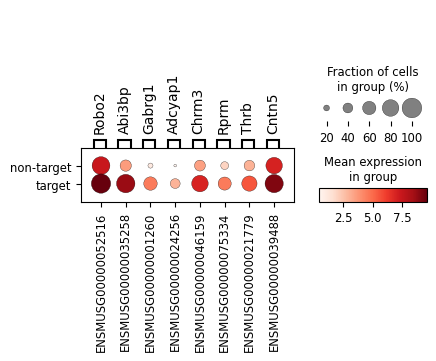

In [5]:
# Create mapping from gene symbols to Ensembl IDs
symbol_to_id = adata.var.reset_index().set_index('gene_symbol')[adata.var.index.name].to_dict()

# Candidate markers for contralaterally-projecting AON neurons
candidate_genes = ['Robo2', 'Abi3bp', 'Gabrg1', 'Adcyap1', 'Chrm3', 'Rprm', 'Thrb', 'Cntn5']

# Filter to genes present in dataset
gene_dict = {symbol: symbol_to_id[symbol] for symbol in candidate_genes if symbol in symbol_to_id}

sc.pl.dotplot(combined, var_names=gene_dict, groupby='group')

In [6]:
adata_subset = adata[adata.obs['group'].isin(['target', 'non-target'])].copy()
adata_subset.obs['target_group'] = adata_subset.obs['group'].replace({
    'target': 'Target',
    'non-target': 'Non-target'
})

sc.tl.rank_genes_groups(
    adata_subset,
    groupby='target_group',
    groups=['Target'],
    reference='Non-target',
    method='wilcoxon',
    key_added='wilcoxon_de'
)

results = sc.get.rank_genes_groups_df(adata_subset, group='Target', key='wilcoxon_de')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Significant upregulated genes: 337
                 names  logfoldchanges      pvals_adj
0   ENSMUSG00000090223        2.186659   0.000000e+00
1   ENSMUSG00000035258        7.287156   0.000000e+00
2   ENSMUSG00000029838        2.694706   0.000000e+00
3   ENSMUSG00000026335        4.748793   0.000000e+00
4   ENSMUSG00000052516        3.150639   0.000000e+00
5   ENSMUSG00000038530        3.319282  5.110701e-303
6   ENSMUSG00000047945        4.969207  7.950196e-294
7   ENSMUSG00000020644        5.124677  5.713877e-280
8   ENSMUSG00000045083        2.999200  9.675608e-271
9   ENSMUSG00000021700        3.044257  8.524059e-261
10  ENSMUSG00000038370        5.231604  1.592050e-253
11  ENSMUSG00000046159        4.981712  4.762935e-248
12  ENSMUSG00000074505        1.995804  1.384071e-243
13  ENSMUSG00000001260        5.696777  2.407786e-240
14  ENSMUSG00000039419        2.375230  3.277386e-228
15  ENSMUSG00000060424        4.426741  4.712843e-226
16  ENSMUSG00000052581        1.039283  5.28727

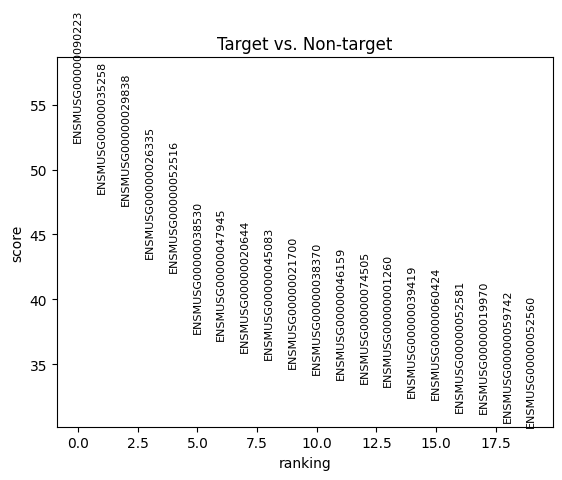

In [7]:
sig_genes = results[
    (results['pvals_adj'] < 0.05) &
    (results['logfoldchanges'] > 1.0)
].copy()
sig_genes = sig_genes.sort_values('scores', ascending=False)

print(f"Significant upregulated genes: {len(sig_genes)}")
print(sig_genes.head(20)[['names', 'logfoldchanges', 'pvals_adj']])

sc.pl.rank_genes_groups(adata_subset, key='wilcoxon_de', groups=['Target'], n_genes=20)

In [8]:
if 'gene_symbol' in adata_subset.var.columns:
    symbol_map = adata_subset.var['gene_symbol'].to_dict()
    sig_genes['gene_symbol'] = sig_genes['names'].map(symbol_map)
else:
    sig_genes['gene_symbol'] = sig_genes['names']

output_path = Path("../output") / "top50_target_vs_nontarget.csv"
sig_genes.head(50).to_csv(output_path, index=False)
print(f"Saved top 50 DE genes to {output_path}")

Saved top 50 DE genes to ../output/top50_target_vs_nontarget.csv
